In [1]:
!pip install opencv-python

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import matplotlib.patches as mpatches
import numpy as np
import cv2
import seaborn as sns

from sklearn import preprocessing, manifold, decomposition, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.cluster import KMeans, MiniBatchKMeans
import re
import time
import pickle

import sys
from os import listdir
import warnings
warnings.filterwarnings("ignore")

## Configuration du chemin d'accès aux données

In [3]:
path_data = './data/'
path_images = path_data + 'Images/'
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


## Chargement des données

Enfin, chargeons le fichier de données des clients pour commencer notre exploration.

In [4]:
# Chargement des données
data = pd.read_csv(path_data + 'data_clean.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_name           1050 non-null   object
 2   image                  1050 non-null   object
 3   description            1050 non-null   object
 4   product_category_tree  1050 non-null   object
 5   main_category          1050 non-null   object
 6   label_main_category    1050 non-null   int64 
 7   sub_category           1050 non-null   object
 8   description_clean      1050 non-null   object
dtypes: int64(1), object(8)
memory usage: 74.0+ KB


# Préparation du dataset

In [6]:
data = data[['image', 'main_category', 'label_main_category']]
data.head(3)

,image,main_category,label_main_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0


## Affichage d'exemples d'images par label

In [7]:
print(data["main_category"].unique())

['Home Furnishing ' 'Baby Care ' 'Watches ' 'Home Decor & Festive Needs '
 'Kitchen & Dining ' 'Beauty and Personal Care ' 'Computers ']


Home Furnishing 


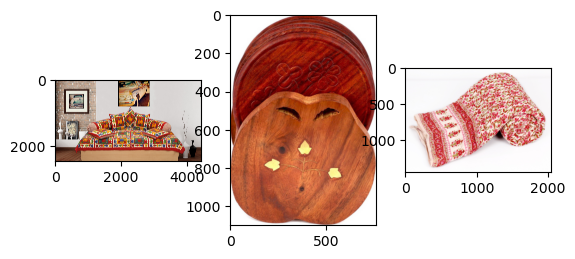

Baby Care 


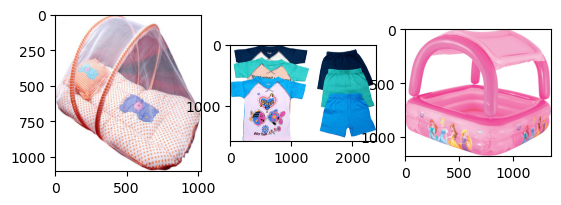

Watches 


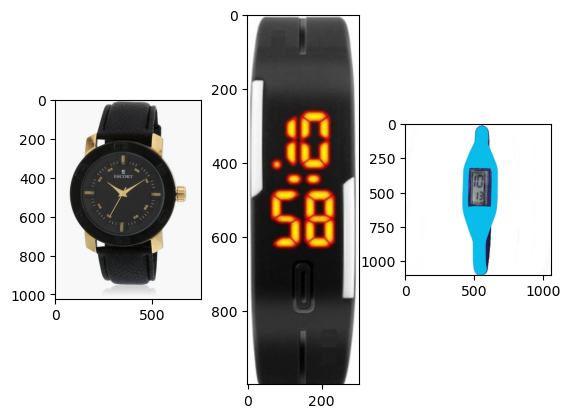

Home Decor & Festive Needs 


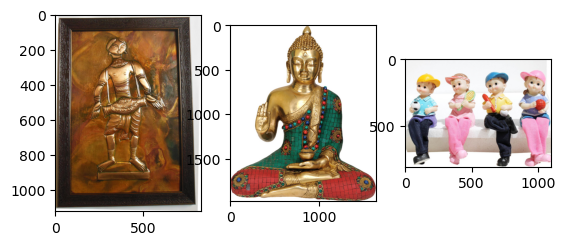

Kitchen & Dining 


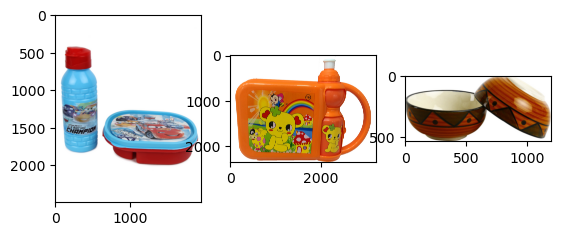

Beauty and Personal Care 


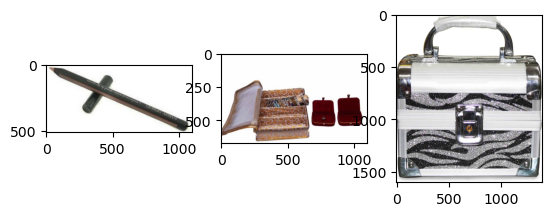

Computers 


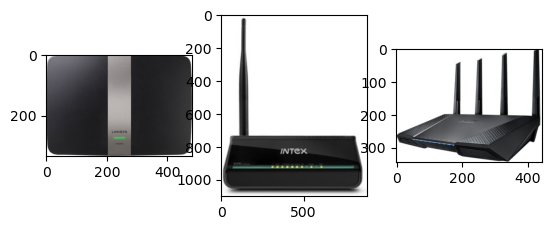

In [8]:
# Fonction pour créer une liste de noms d'images pour une catégorie donnée
def list_fct(name):
    return [data['image'][i] for i in range(len(data)) if data['main_category'][i] == name]

# Liste des labels uniques
list_labels = data['main_category'].unique()

# Affichage d'exemples d'images par label
for name in list_labels:
    print(name)
    image_list = list_fct(name)
    
    # Vérifier si la liste contient au moins 13 éléments
    if len(image_list) > 13:
        for i in range(3):
            plt.subplot(130 + 1 + i)
            filename = path_images + image_list[i + 10]
            image = imread(filename)
            plt.imshow(image)
        plt.show()
    else:
        print(f"Pas assez d'images dans la catégorie {name} pour afficher des exemples.")


# Étape 3 : Étudiez la faisabilité de classification en utilisant des techniques de traitement d'image basiques

## Section 1 : Analysez les images via différentes méthodes de transformation.

### Visualisation des images dans le dossier local

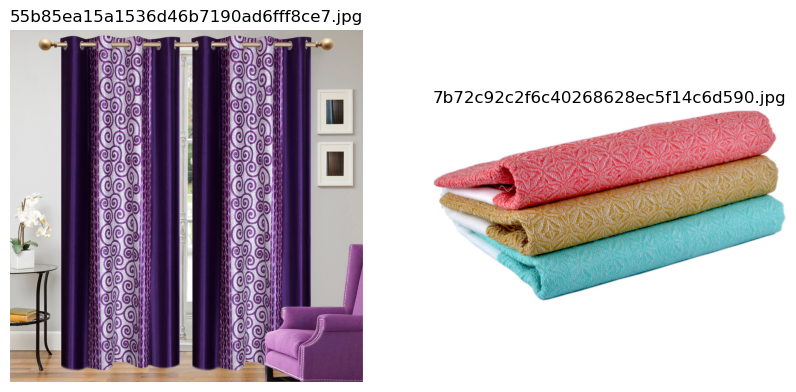

In [9]:
image_files = ['55b85ea15a1536d46b7190ad6fff8ce7.jpg', '7b72c92c2f6c40268628ec5f14c6d590.jpg']

fig, axes = plt.subplots(1, len(image_files), figsize=(10, 5))
for ax, image_file in zip(axes, image_files):
    img = mpimg.imread(path_images + image_file)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(image_file)

plt.show()

### Transformations d'Image

Nous allons appliquer quelques transformations courantes qui sont utiles dans le traitement d'images :

1. **Conversion en niveau de gris :** pour réduire la complexité des images en éliminant la couleur.
2. **Filtrage du bruit :** pour lisser l'image.
3. **Ajustement du contraste :** pour améliorer la visibilité des caractéristiques importantes.

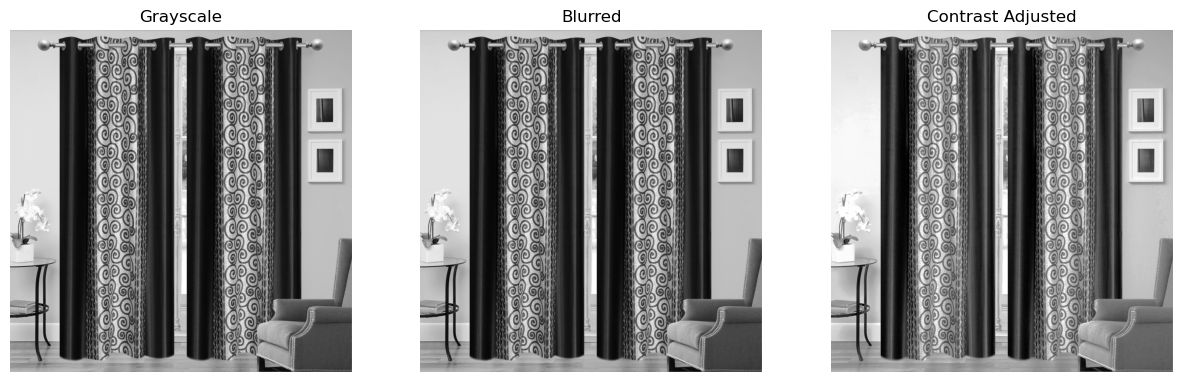

In [10]:
# Fonction pour appliquer des transformations d'image
def apply_transformations(image_path):
    """
    Applique des transformations d'image standard pour préparer les images pour des traitements ultérieurs.
    
    Paramètres:
    image_path (str): Chemin vers l'image à transformer.
    
    Retourne:
    tuple: contenant l'image en niveaux de gris, l'image floutée et l'image avec le contraste ajusté.
    """
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    contrast_adjusted = cv2.equalizeHist(blurred_image)
    
    return gray_image, blurred_image, contrast_adjusted


gray, blurred, contrast = apply_transformations(path_images + '55b85ea15a1536d46b7190ad6fff8ce7.jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
images = [gray, blurred, contrast]
titles = ['Grayscale', 'Blurred', 'Contrast Adjusted']

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

plt.show()

## Section 2 : Utilisation de SIFT (Scale-Invariant Feature Transform)

### Détermination et affichage des descripteurs SIFT

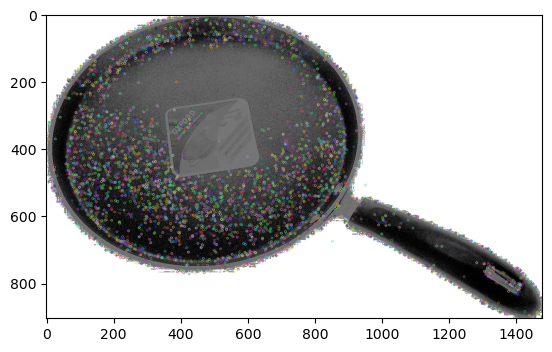

Descripteurs :  (4656, 128)

[[ 4.  2.  6. ...  5.  0.  0.]
 [96. 20.  0. ...  9.  2.  0.]
 [55. 16.  0. ...  0.  1.  0.]
 ...
 [12.  0.  0. ...  0.  0.  0.]
 [67. 19.  5. ...  0. 34. 13.]
 [ 0.  5. 27. ...  0.  0.  0.]]


In [11]:
sift = cv2.SIFT_create()
image = cv2.imread(path_images + list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

### Pré-traitement des images via SIFT

#### Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [13]:
# Initialisation de SIFT
sift = cv2.SIFT_create(nfeatures=500)

# Liste pour stocker les descripteurs
sift_keypoints = []

# Démarrer le chronomètre
temps1 = time.time()

# Parcourir les images et extraire les descripteurs SIFT
for image_num in range(len(list_photos)):
    if image_num % 100 == 0:
        print(f"Traitement de l'image numéro {image_num}")
    
    image = cv2.imread(path_images+list_photos[image_num],0)
    
    # Vérifier si l'image a été lue correctement
    if image is None:
        print(f"Erreur de lecture de l'image : {image_path}")
        continue
    
    # Égaliser l'histogramme de l'image
    res = cv2.equalizeHist(image)
    
    # Détecter les points clés et calculer les descripteurs
    kp, des = sift.detectAndCompute(res, None)
    
    # Vérifier si des descripteurs ont été trouvés
    if des is not None:
        sift_keypoints.append(des)

# Convertir la liste en un tableau numpy
sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)

# Concaténer tous les descripteurs en un seul tableau
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

# Afficher le nombre de descripteurs extraits
print(f"\nNombre de descripteurs : {sift_keypoints_all.shape}\n")

# Calculer et afficher le temps de traitement
duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

Traitement de l'image numéro 0
Traitement de l'image numéro 100
Traitement de l'image numéro 200
Traitement de l'image numéro 300
Traitement de l'image numéro 400
Traitement de l'image numéro 500
Traitement de l'image numéro 600
Traitement de l'image numéro 700
Traitement de l'image numéro 800
Traitement de l'image numéro 900
Traitement de l'image numéro 1000

Nombre de descripteurs : (517351, 128)

Temps de traitement SIFT descriptor :           770.68 secondes


#### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [16]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print(f"Nombre de clusters estimés : {k}")
print(f"Création de {k} clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=3)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print(f"Temps de traitement kmeans : {duration1:15.2f} secondes")

Nombre de clusters estimés : 719
Création de 719 clusters de descripteurs ...
Temps de traitement kmeans :           13.76 secondes


In [17]:
# Version sans "MiniBatchKMeans"
'''
# Détermination du nombre de clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print(f"Nombre de clusters estimés : {k}")
print(f"Création de {k} clusters de descripteurs ...")

# Clustering
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time() - temps1
print(f"Temps de traitement kmeans : {duration1:15.2f} secondes")
'''

'\n# Détermination du nombre de clusters\ntemps1 = time.time()\n\nk = int(round(np.sqrt(len(sift_keypoints_all)), 0))\nprint(f"Nombre de clusters estimés : {k}")\nprint(f"Création de {k} clusters de descripteurs ...")\n\n# Clustering\nkmeans = KMeans(n_clusters=k, random_state=0)\nkmeans.fit(sift_keypoints_all)\n\nduration1 = time.time() - temps1\nprint(f"Temps de traitement kmeans : {duration1:15.2f} secondes")\n'

#### Création des features des images
* Pour chaque image : 
   - Prédiction des numéros de cluster de chaque descripteur
   - Création d'un histogramme comptant pour chaque numéro de cluster le nombre de descripteurs de l'image
   - Les features d'une image sont représentées par l'histogramme, qui compte le nombre de descripteurs par cluster

In [18]:
# Fonction pour construire l'histogramme
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print(f"Problème histogramme image : {image_num}")
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

# Création des histogrammes (features)
temps1 = time.time()

# Création d'une matrice d'histogrammes
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(f"Processing image {i}")
    hist = build_histogram(kmeans, image_desc, i)  # Calcule l'histogramme
    hist_vectors.append(hist)  # L'histogramme est le vecteur de features

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print(f"Temps de création des histogrammes : {duration1:15.2f} secondes")


Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600
Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Temps de création des histogrammes :            4.36 secondes


## Section 3 : Utilisez des méthodes de réduction de dimension sur les images encodées et comparer les résultats avec les catégories réelles.

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [19]:
print(f"Dimensions dataset avant réduction PCA : {im_features.shape}")
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print(f"Dimensions dataset après réduction PCA : {feat_pca.shape}")

Dimensions dataset avant réduction PCA : (1050, 719)
Dimensions dataset après réduction PCA : (1050, 491)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [20]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=10)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["main_category"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

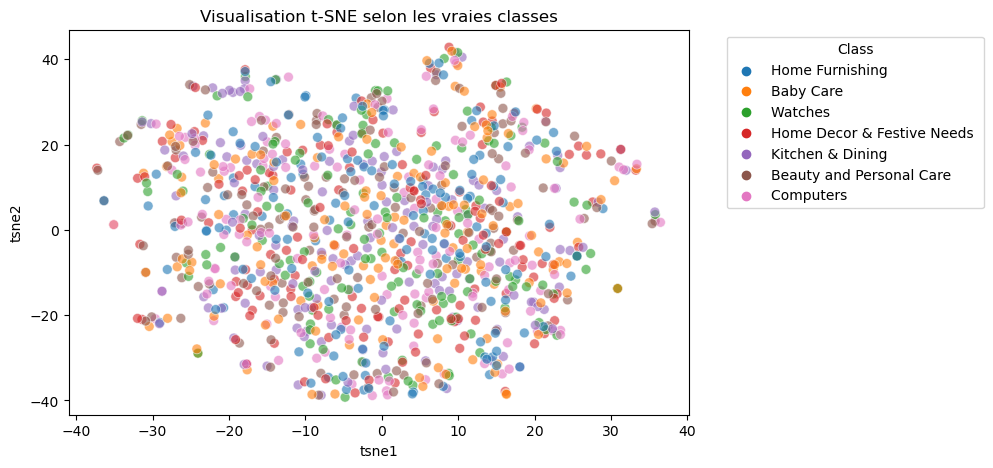

In [21]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('Visualisation t-SNE selon les vraies classes')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [22]:
num_cluster = 7
cls = cluster.KMeans(n_clusters=num_cluster, random_state=11)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

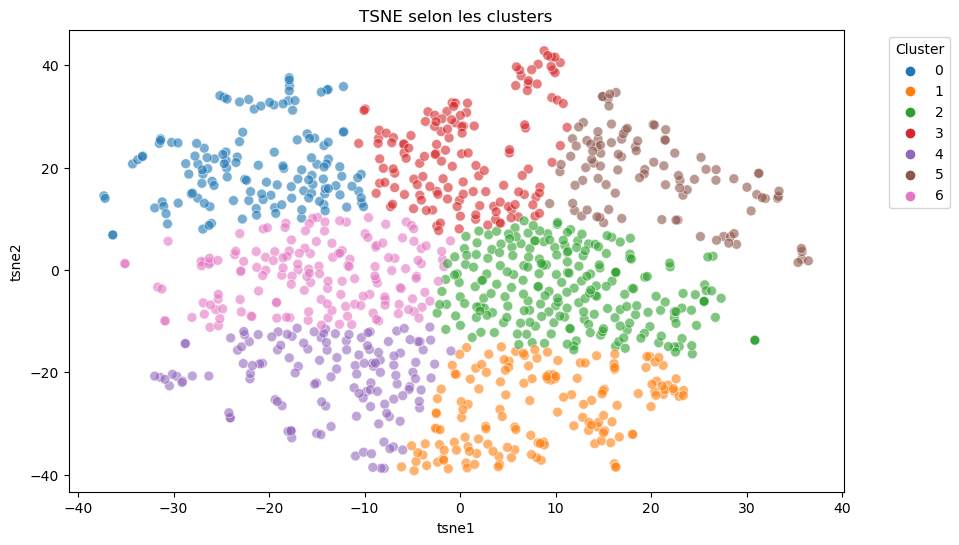

ARI :  -0.0010452854002161933


In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

# Titre et étiquettes des axes avec un formatage personnalisé
plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')

# Position de la légende
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Affichage du graphique
plt.show()

labels = data["label_main_category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes
* La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne
* Cette transformation atteint ses limites pour les 2 catégories "shine" et "sunshine" qui sont peu séparées (donc elle a été réalisée manuellement au lieu d'utiliser la fonction "argmax")

In [24]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    136
1    152
2    230
3    140
4    135
5    100
6    157
Name: class, dtype: int64

In [25]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[17 17 42 20 18 15 21]
 [18 16 26 21 23 15 31]
 [23 24 30 19 20 14 20]
 [18 24 30 19 24 17 18]
 [17 25 31 24 15 14 24]
 [26 22 31 18 22 11 20]
 [17 24 40 19 13 14 23]]


In [26]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6, 5, 4, 3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6, 5, 4, 3, 1, 2, 0]
[[21 18 15 20 42 17 17]
 [31 23 15 21 26 16 18]
 [20 20 14 19 30 24 23]
 [18 24 17 19 30 24 18]
 [24 15 14 24 31 25 17]
 [20 22 11 18 31 22 26]
 [23 13 14 19 40 24 17]]

              precision    recall  f1-score   support

           0       0.13      0.14      0.14       150
           1       0.17      0.15      0.16       150
           2       0.14      0.09      0.11       150
           3       0.14      0.13      0.13       150
           4       0.13      0.21      0.16       150
           5       0.14      0.15      0.15       150
           6       0.12      0.11      0.12       150

    accuracy                           0.14      1050
   macro avg       0.14      0.14      0.14      1050
weighted avg       0.14      0.14      0.14      1050



<AxesSubplot:>

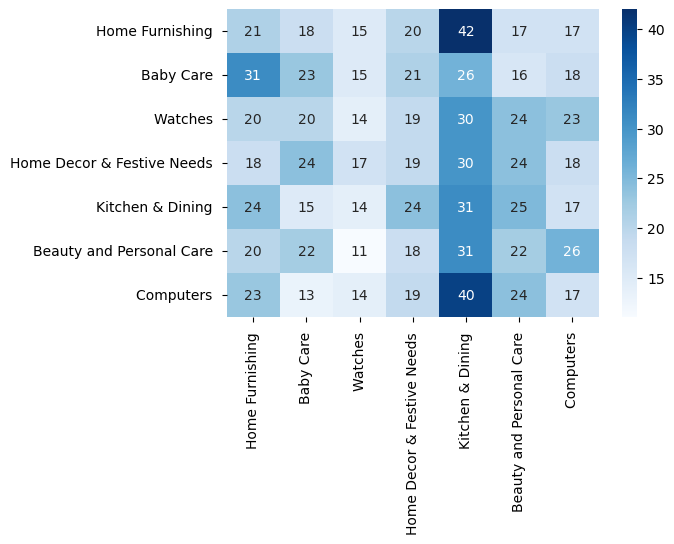

In [27]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in list_labels])

fmt = 'd'
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues",  fmt=fmt)